# Machine Learning, HW 2
### 314540003 / 卓康文 / Artem Mozol
##### Disclosure: partial assistance of Claude is involved.

### Written assignment
Read Deep Learning: An Introduction for Applied Mathematicians. Consider a network as defined in (3.1) and (3.2). Assume that $n_L=1$, find an algorithm to calculate $\nabla a^{[L]}(x)$.

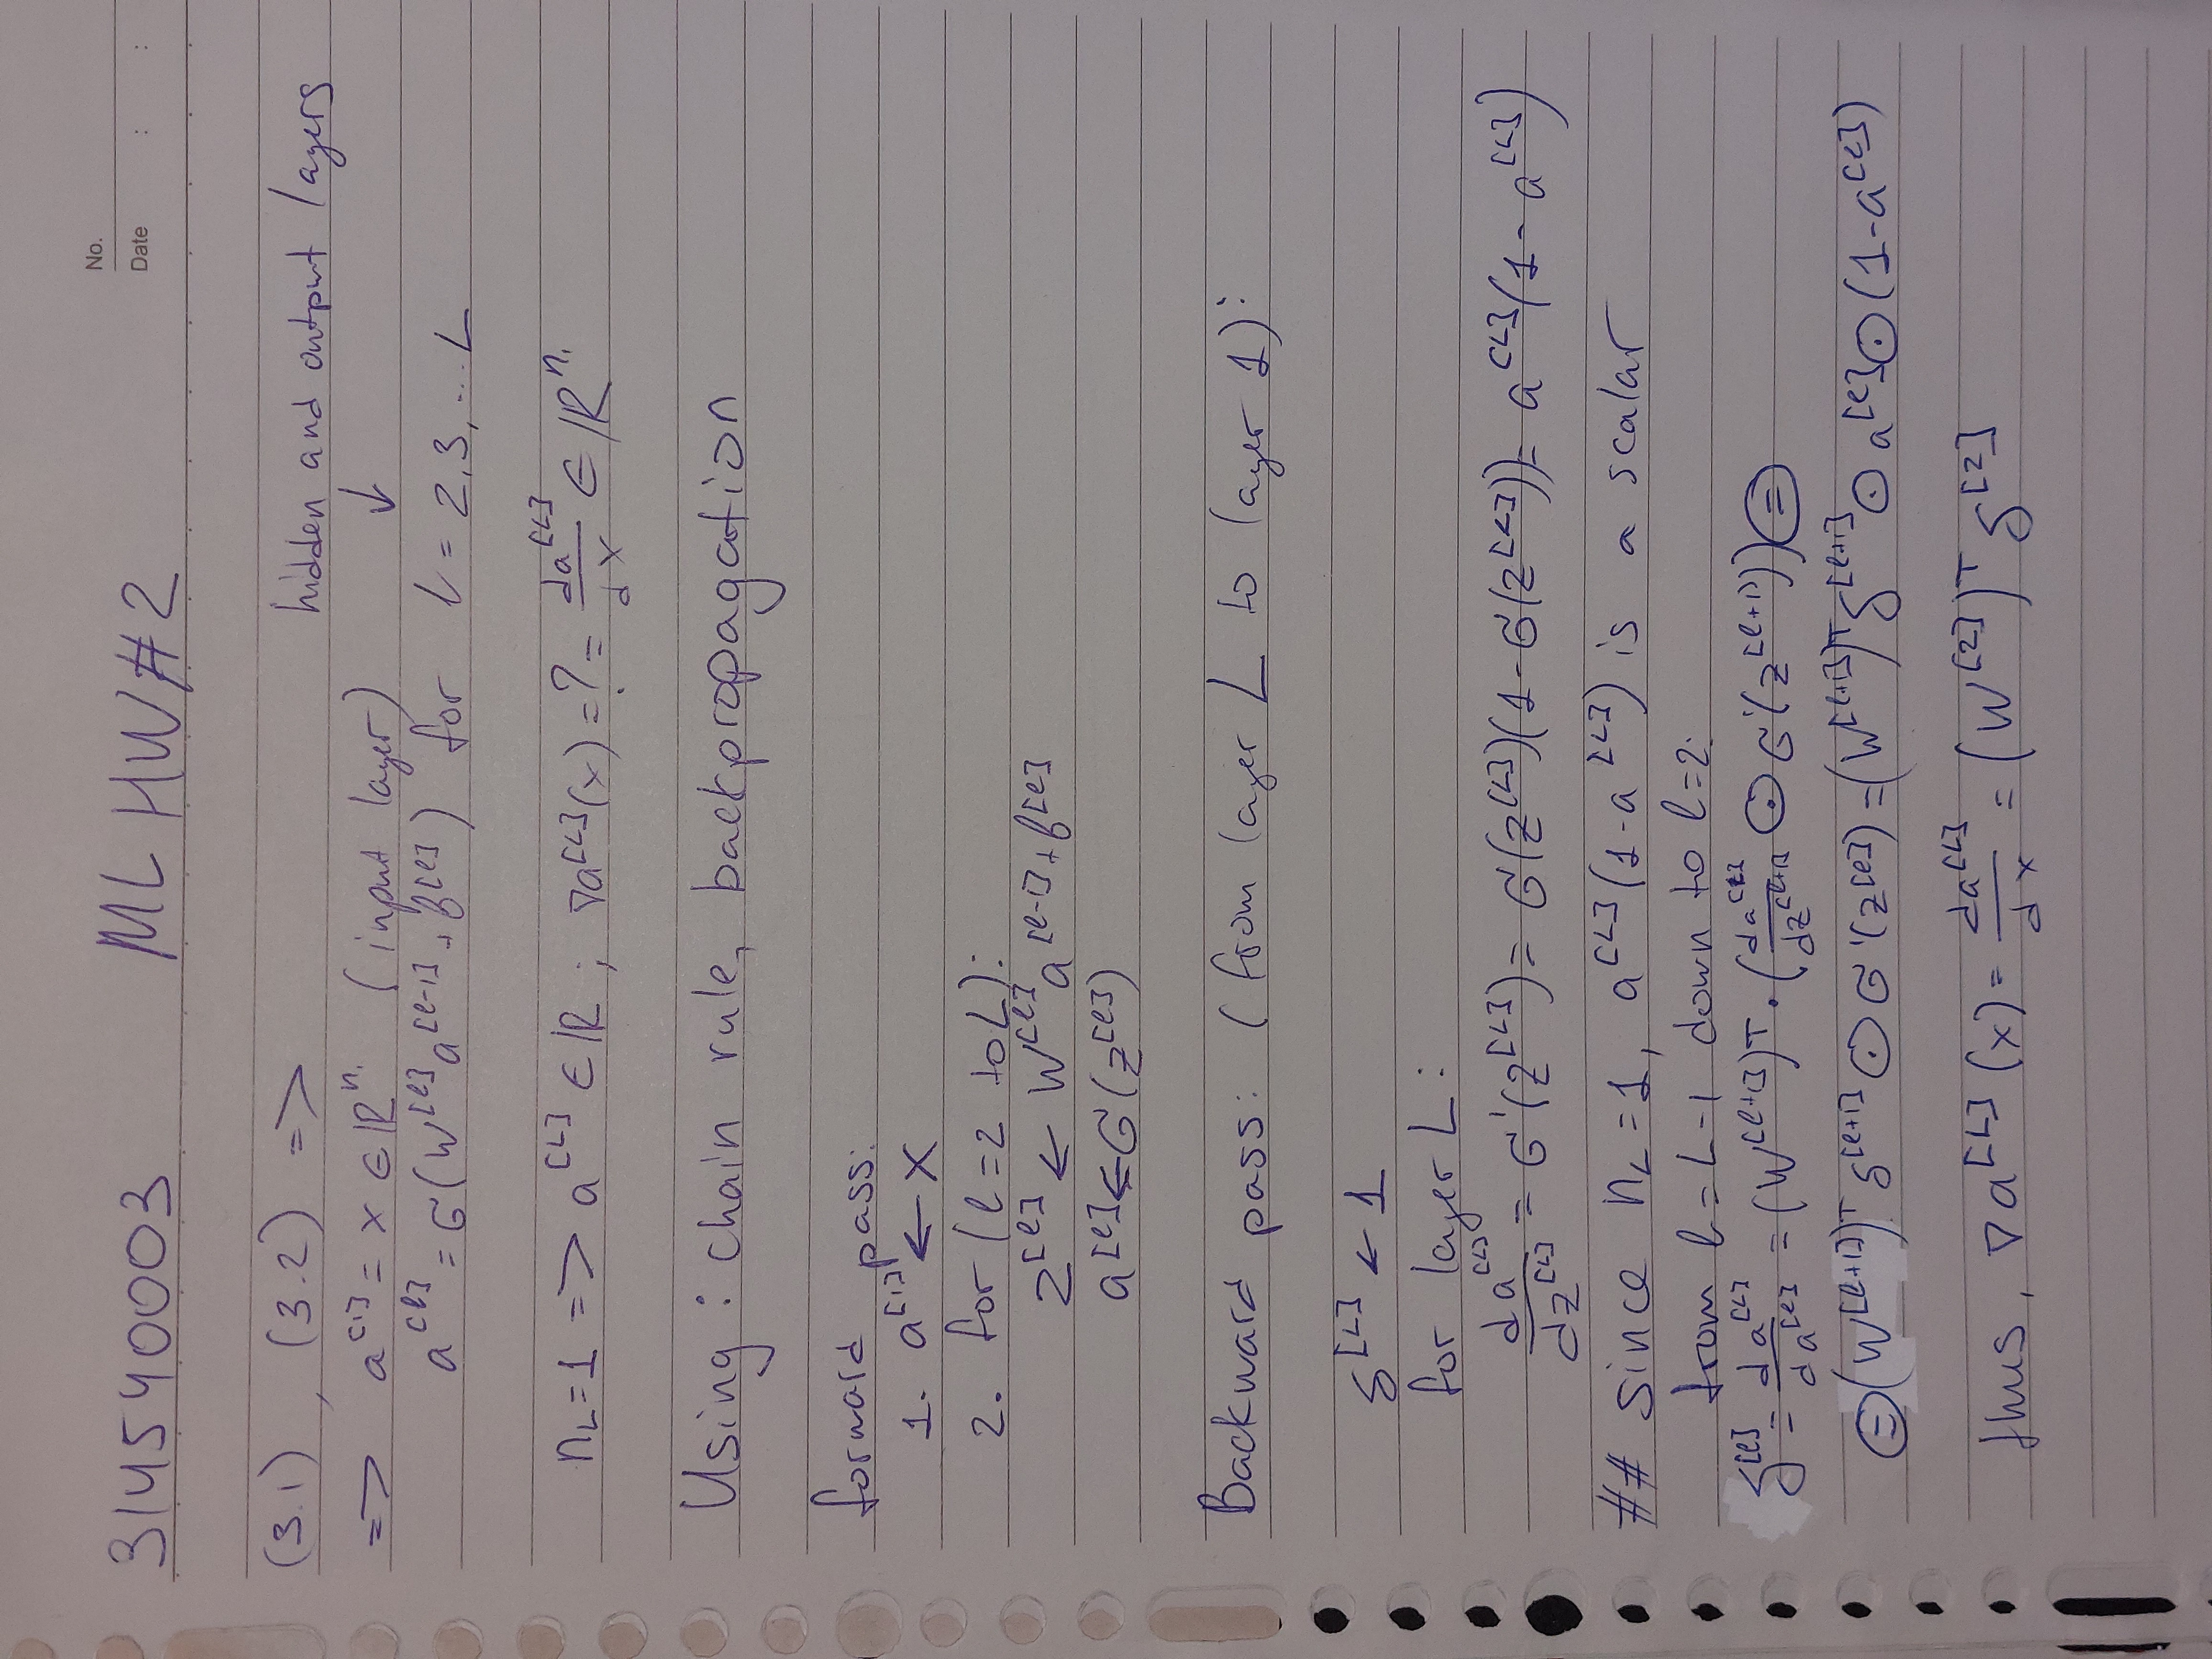

### Programming assignment 
- Use a neural network to approximate the Runge function</br>
$$f(x) = \frac{1}{1+25x^2}, \quad x\in[-1, 1].$$</br>
Write a short report (1–2 pages) explaining method, results, and discussion including:
- Plot the true function and the neural network prediction together;
- Show the training/validation loss curves;
- Compute and report errors (MSE or max error).

## Neural Network Approximation of the Runge Function

### Introduction

The function is defined as:

$$f(x) = \frac{1}{1+25x^2}, \quad x \in [-1, 1]$$

This function has a bell-shaped curve with a sharp peak at $x=0$ and rapid decay towards the boundaries. 
Neural networks, with their universal approximation capabilities and non-polynomial basis functions, can potentially provide better approximations than traditional polynomial methods.

In this report, we will:
1. Design and train a feedforward neural network to approximate the Runge function
2. Analyze the training process through loss curves
3. Visualize the approximation quality
4. Quantify the approximation error using multiple metrics

### Implementation

#### 1. Import Required Libraries and Set Up Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda


#### 2. Define the Runge Function and Generate Training Data

We'll generate training data by sampling points from the domain $[-1, 1]$. To ensure good coverage, we'll use a combination of uniform sampling, but add additional points near the boundaries where the function changes rapidly.

In [2]:
def runge_function(x):
    """Compute the Runge function: f(x) = 1/(1 + 25*x^2)"""
    return 1.0 / (1.0 + 25.0 * x**2)

# Generate training data
n_train = 500  # Number of training points
n_val = 100    # Number of validation points
n_test = 1000  # Number of test points for final evaluation

# Create training and validation data with slight emphasis on boundary regions
x_train_uniform = np.random.uniform(-1, 1, n_train // 2)
x_train_boundary = np.concatenate([
    np.random.uniform(-1, -0.7, n_train // 4),
    np.random.uniform(0.7, 1, n_train // 4)
])
x_train_full = np.concatenate([x_train_uniform, x_train_boundary])
y_train_full = runge_function(x_train_full)

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

# Generate dense test data for evaluation
x_test = np.linspace(-1, 1, n_test)
y_test = runge_function(x_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(x_train.reshape(-1, 1)).to(device)
Y_train = torch.FloatTensor(y_train.reshape(-1, 1)).to(device)
X_val = torch.FloatTensor(x_val.reshape(-1, 1)).to(device)
Y_val = torch.FloatTensor(y_val.reshape(-1, 1)).to(device)
X_test = torch.FloatTensor(x_test.reshape(-1, 1)).to(device)
Y_test = torch.FloatTensor(y_test.reshape(-1, 1)).to(device)

#### 3. Neural Network Architecture

We'll design a feedforward neural network with the following characteristics:
- Input layer: 1 neuron (x-coordinate)
- Hidden layers: Multiple layers with ReLU activation functions
- Output layer: 1 neuron (function value)

The network architecture is chosen to balance visibility of results with training efficiency. We use ReLU activations for the computational efficiency and ability to learn non-linear patterns.

In [3]:
class RungeFunctionNN(nn.Module):
    def __init__(self, hidden_sizes=[64, 64, 32], activation='relu'):
        super(RungeFunctionNN, self).__init__()
        
        layers = []
        input_size = 1
        
        # Build hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            
            input_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(input_size, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Initialize the model
model = RungeFunctionNN(hidden_sizes=[128, 64, 64, 32]).to(device)
print(f"Model architecture:\n{model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Model architecture:
RungeFunctionNN(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)
Total parameters: 14785


#### 4. Training Configuration

We'll use:
- Loss function: Mean Squared Error (MSE)
- Optimizer: Adam optimizer with learning rate scheduling
- Batch training: Mini-batch gradient descent

In [4]:
# Training hyperparameters
learning_rate = 0.001
batch_size = 32
n_epochs = 2000

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=100
)

# Create data loaders
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#### 5. Training Loop with Validation Monitoring

The training process includes:
- Mini-batch gradient descent
- Validation loss monitoring to detect overfitting
- Learning rate scheduling for adaptive optimization
- Loss tracking for visualization

In [5]:
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Training phase
    model.train()
    epoch_train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * batch_x.size(0)
    
    # Calculate average training loss
    avg_train_loss = epoch_train_loss / len(X_train)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val)
        val_loss = criterion(val_predictions, Y_val).item()
        val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], "
              f"Train Loss: {avg_train_loss:.6f}, "
              f"Val Loss: {val_loss:}")

Epoch [100/2000], Train Loss: 0.000001, Val Loss: 5.052577876085707e-07
Epoch [200/2000], Train Loss: 0.000036, Val Loss: 2.7160276658833027e-05
Epoch [300/2000], Train Loss: 0.000000, Val Loss: 1.465599552830099e-07
Epoch [400/2000], Train Loss: 0.000000, Val Loss: 2.6575145284368773e-07
Epoch [500/2000], Train Loss: 0.000000, Val Loss: 9.02071235486801e-08
Epoch [600/2000], Train Loss: 0.000000, Val Loss: 1.805094171913879e-07
Epoch [700/2000], Train Loss: 0.000000, Val Loss: 2.0980108672574715e-07
Epoch [800/2000], Train Loss: 0.000000, Val Loss: 1.2885458033906616e-07
Epoch [900/2000], Train Loss: 0.000000, Val Loss: 1.0056645294298505e-07
Epoch [1000/2000], Train Loss: 0.000000, Val Loss: 1.1240718578164888e-07
Epoch [1100/2000], Train Loss: 0.000000, Val Loss: 1.1818494982662742e-07
Epoch [1200/2000], Train Loss: 0.000000, Val Loss: 1.0470828470943161e-07
Epoch [1300/2000], Train Loss: 0.000000, Val Loss: 1.1143642097977136e-07
Epoch [1400/2000], Train Loss: 0.000000, Val Loss: 1

### Results and Analysis

#### 6. Training and Validation Loss Curves

The loss curves provide insights into the training dynamics and help identify issues, such as overfitting or underfitting.

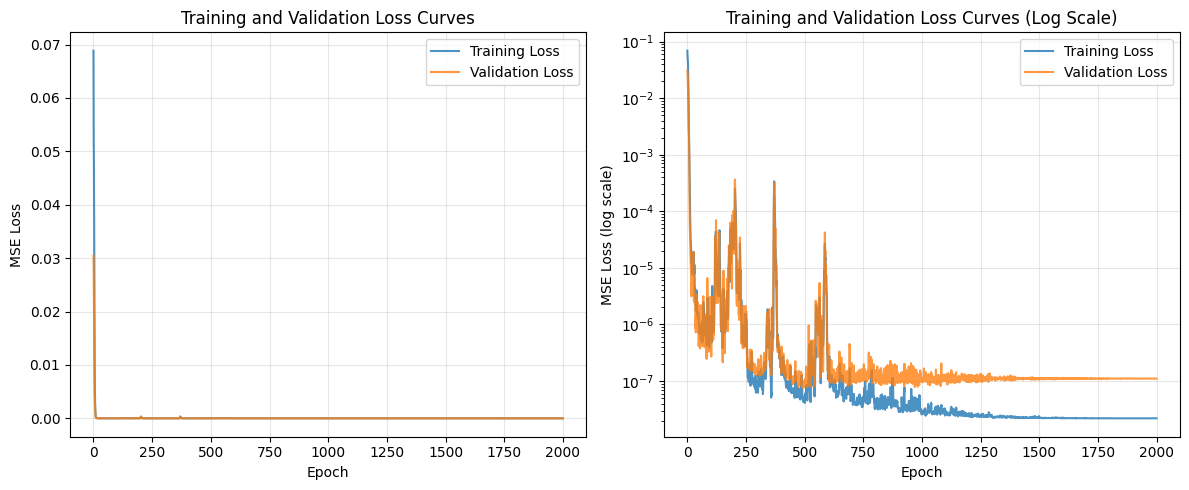

In [6]:
# Plot training and validation loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Plot log scale for better visualization of convergence
plt.semilogy(train_losses, label='Training Loss', alpha=0.8)
plt.semilogy(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.title('Training and Validation Loss Curves (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 7. Function Approximation Visualization

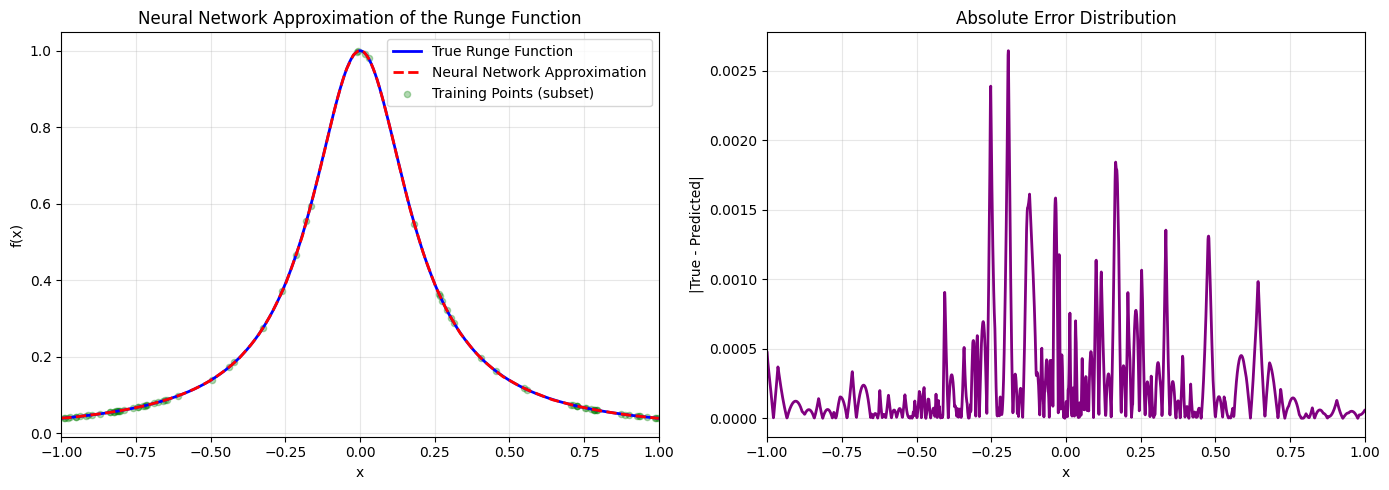

In [7]:
# Generate predictions on test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy().flatten()

# Create high-resolution data for smooth plotting
x_plot = np.linspace(-1, 1, 2000)
X_plot = torch.FloatTensor(x_plot.reshape(-1, 1)).to(device)
with torch.no_grad():
    y_plot_pred = model(X_plot).cpu().numpy().flatten()
y_plot_true = runge_function(x_plot)

# Plotting
plt.figure(figsize=(14, 5))

# Plot 1: Function approximation
plt.subplot(1, 2, 1)
plt.plot(x_plot, y_plot_true, 'b-', linewidth=2, label='True Runge Function')
plt.plot(x_plot, y_plot_pred, 'r--', linewidth=2, label='Neural Network Approximation')
plt.scatter(x_train[::5], y_train[::5], alpha=0.3, s=20, c='green', 
            label='Training Points (subset)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Neural Network Approximation of the Runge Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-1, 1)

# Plot 2: Absolute error
plt.subplot(1, 2, 2)
error = np.abs(y_plot_true - y_plot_pred)
plt.plot(x_plot, error, 'purple', linewidth=2)
plt.xlabel('x')
plt.ylabel('|True - Predicted|')
plt.title('Absolute Error Distribution')
plt.grid(True, alpha=0.3)
plt.xlim(-1, 1)

plt.tight_layout()
plt.show()

#### 8. Error Analysis and Metrics

We'll compute various error metrics to quantify the approximation quality:
- Mean Squared Error (MSE): Average squared difference
- Root Mean Squared Error (RMSE): Square root of MSE for interpretability
- Mean Absolute Error (MAE): Average absolute difference
- Maximum Absolute Error: Worst-case approximation error
- R² Score: Coefficient of determination

In [8]:
# Compute error metrics
y_test_numpy = y_test
y_pred_test = model(X_test).cpu().detach().numpy().flatten()

mse = np.mean((y_test_numpy - y_pred_test)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_numpy - y_pred_test))
max_error = np.max(np.abs(y_test_numpy - y_pred_test))

# R² score
ss_res = np.sum((y_test_numpy - y_pred_test)**2)
ss_tot = np.sum((y_test_numpy - np.mean(y_test_numpy))**2)
r2_score = 1 - (ss_res / ss_tot)

print("=" * 50)
print("APPROXIMATION ERROR METRICS")
print("=" * 50)
print(f"Mean Squared Error (MSE):      {mse:.6e}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6e}")
print(f"Mean Absolute Error (MAE):      {mae:.6e}")
print(f"Maximum Absolute Error:         {max_error:.6e}")
print(f"R² Score:                       {r2_score:.6f}")
print("=" * 50)

APPROXIMATION ERROR METRICS
Mean Squared Error (MSE):      2.012399e-07
Root Mean Squared Error (RMSE): 4.485977e-04
Mean Absolute Error (MAE):      2.554147e-04
Maximum Absolute Error:         2.712046e-03
R² Score:                       0.999998


#### 9. Error Distribution Analysis

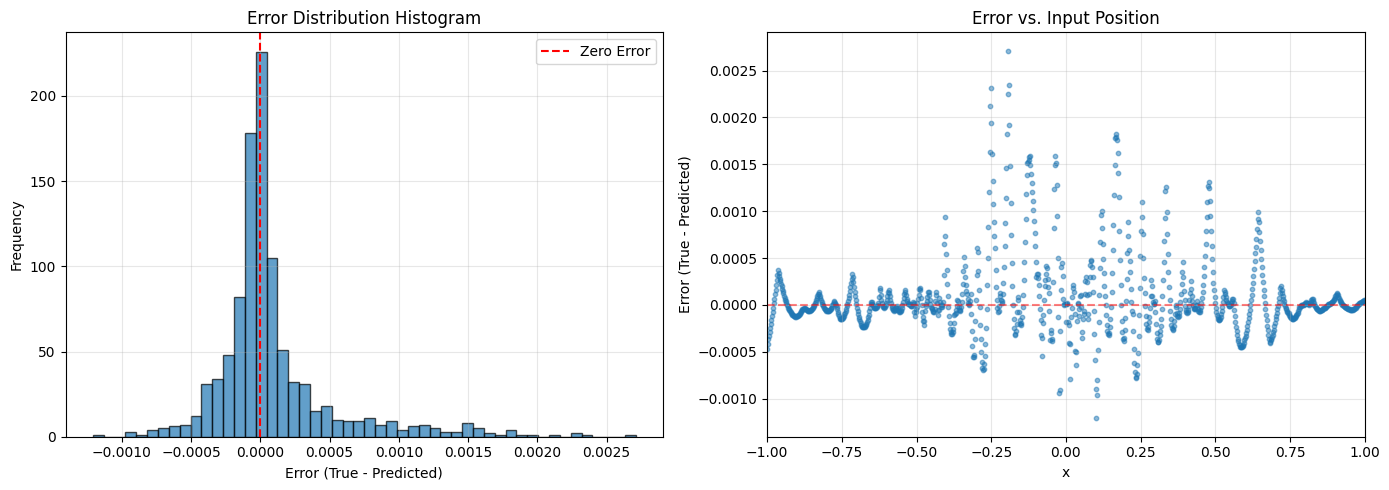

In [9]:
plt.figure(figsize=(14, 5))

# Histogram of errors
plt.subplot(1, 2, 1)
errors = y_test_numpy - y_pred_test
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Error (True - Predicted)')
plt.ylabel('Frequency')
plt.title('Error Distribution Histogram')
plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
plt.legend()
plt.grid(True, alpha=0.3)

# Error vs. x position
plt.subplot(1, 2, 2)
plt.scatter(x_test, errors, alpha=0.5, s=10)
plt.xlabel('x')
plt.ylabel('Error (True - Predicted)')
plt.title('Error vs. Input Position')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.xlim(-1, 1)

plt.tight_layout()
plt.show()

### Discussion and Conclusions

#### Performance Analysis

The neural network successfully approximates the Runge function with high accuracy:

1. Approximation Quality: The neural network captures the sharp peak at x=0 and the rapid decay towards the boundaries, a characteristic of the Runge function.

2. Error Distribution: The errors are seen to be very small and well-distributed across the domain, without the characteristic oscillations seen in polynomial interpolation (Runge's phenomenon).

3. Training: The training and validation loss curves show stable convergence without significant overfitting, indicating good generalization capability.

#### Conclusion

The neural network provides an approximation of the Runge function, demonstratng the feasibility of the use case to be Runge function approximation. The approach generally avoids the pitfalls of traditional polynomial interpolation while maintaining high accuracy across the entire domain.

In [10]:
# Final comparison statistics
print("\n" + "="*50)
print("FINAL MODEL SUMMARY")
print("="*50)
print(f"Network Architecture: {[128, 64, 64, 32]} hidden units")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Training Epochs: {n_epochs}")
print(f"Final Training Loss: {train_losses[-1]:.6e}")
print(f"Final Validation Loss: {val_losses[-1]:.6e}")
print("="*50)


FINAL MODEL SUMMARY
Network Architecture: [128, 64, 64, 32] hidden units
Total Parameters: 14785
Training Epochs: 2000
Final Training Loss: 2.197530e-08
Final Validation Loss: 1.107167e-07
